In [2]:
# Setting up environment
import sys
import pandas as pd
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:50:52 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:50:52 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:50:52 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [3]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))



In [4]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36319")
client

<Client: 'tcp://127.0.0.1:36319' processes=4 threads=16, memory=125.81 GiB>

In [6]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=1),2,3e8,4e8)
da_101_stacked['doy_decimal'] = da_101_stacked.time.dt.dayofyear + (da_101_stacked.time.dt.hour / 24) + (da_101_stacked.time.dt.minute / 1440) + (da_101_stacked.time.dt.second / 86400)


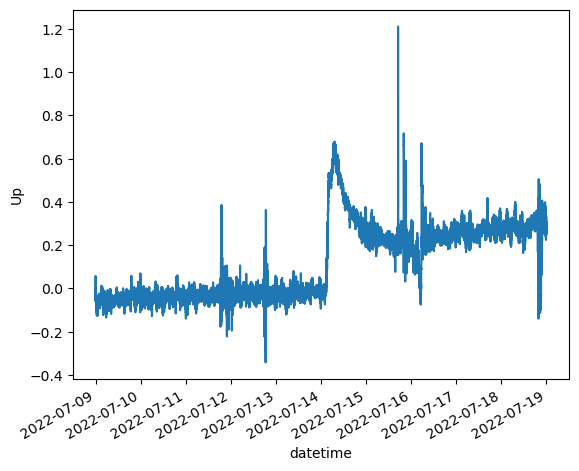

In [7]:
data = pd.read_csv('../sq11.csv')
data['datetime']=  pd.to_datetime(
                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
                      )

data = data.set_index('datetime')
data = data.to_xarray()
data.Up.plot(x='datetime')

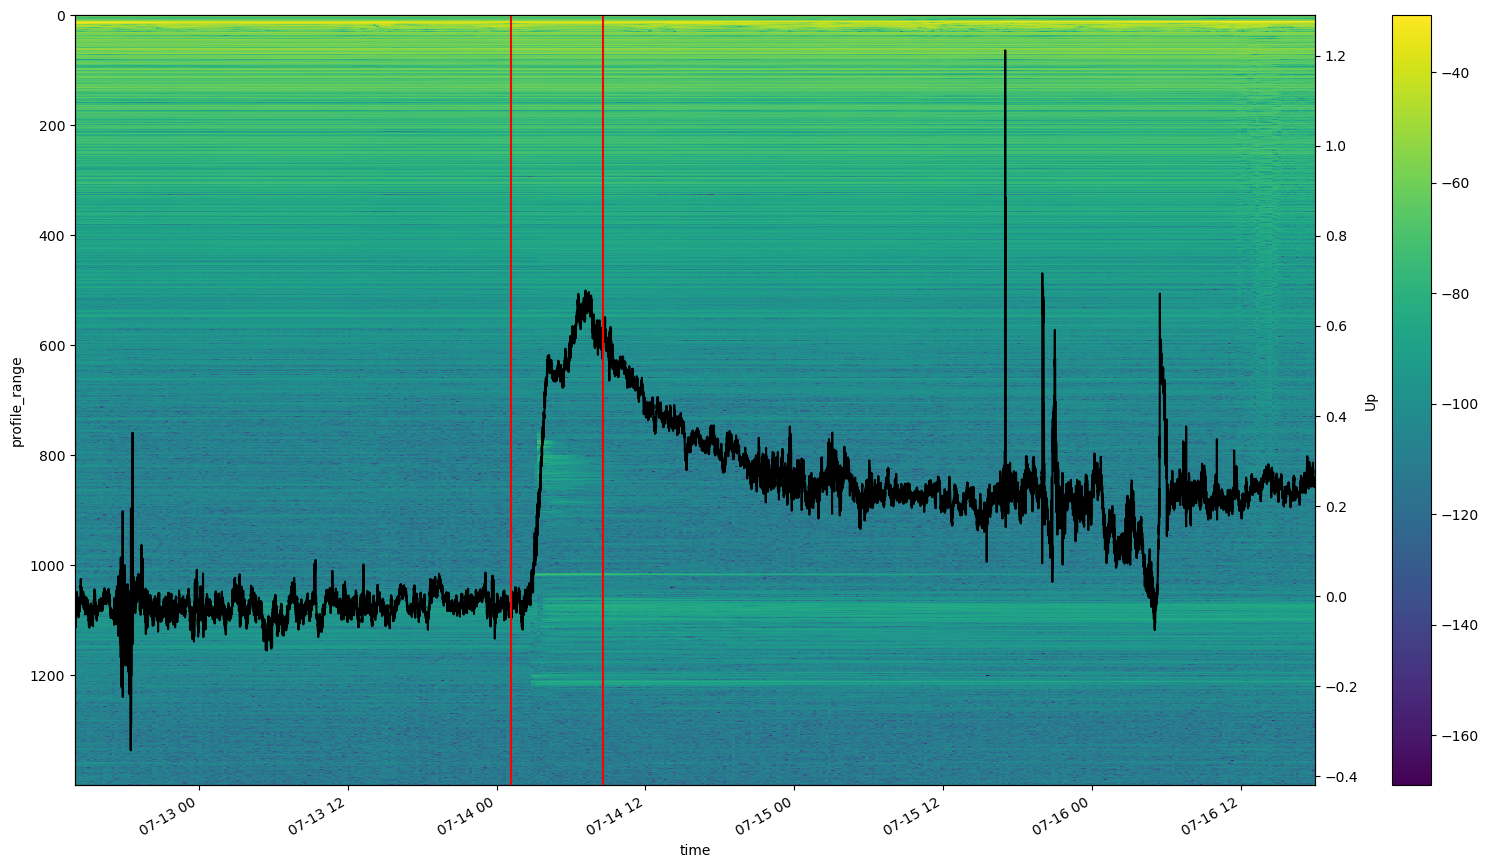

In [8]:
# Checking chirps
drainage_window = da_101_stacked.isel(time=range(4500,4900))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
xa.dB(drainage_window).plot(ax=ax,x='time')
ax.invert_yaxis()
ax1 = ax.twinx()
data.Up.plot(ax=ax1,x='datetime',color='k')
plt.axvline(drainage_window.time[140].values,color = 'r')
plt.axvline(drainage_window.time[170].values,color = 'r')

In [9]:
# Plot stacked chirps from this window
chirps = ds_101.chirp.isel(attenuator_setting_pair=0,time=range(4640,4670))
stacked_chirps = chirps.mean(dim='chirp_num').compute()

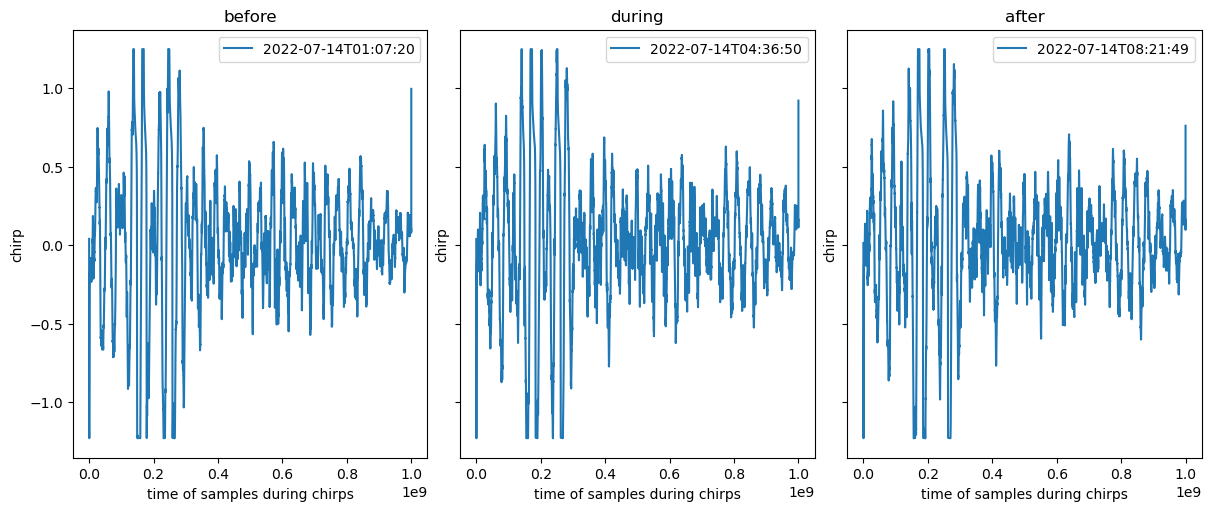

In [10]:
fig, axs = plt.subplots(ncols=3,figsize=(12,5),sharey=True,layout='constrained')
for i,t,label in zip(range(3),[0,14,-1],['before','during','after']):
    to_plot = stacked_chirps.isel(time=t)
    to_plot.plot(ax=axs[i],label = f'{to_plot.time.values:.19}')
    axs[i].set_title(label)
    axs[i].legend()

In [11]:
def convert_to_seconds(s):
    seconds_per_unit = {"S": 1, "T": 60, "H": 3600, "D": 86400, "W": 604800}
    return int(s[:-1]) * seconds_per_unit[s[-1]]

def sum_error(errs):
    return np.sqrt(np.sum(errs**2))

def error_prop(data):
    return xr.apply_ufunc(sum_error, data, input_core_dims=[["time"]], vectorize = True)

In [12]:
# Calculate differing strain rates
longer = da_101_stacked.isel(time=range(2000,7000))
b1 = longer.isel(time=range(0,len(longer)-1))
b2 = longer.isel(time=range(1,len(longer)))
ds, co, phi = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)

INFO     15:53:21 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [900. 904. 895. ... 901. 900. 900.]s


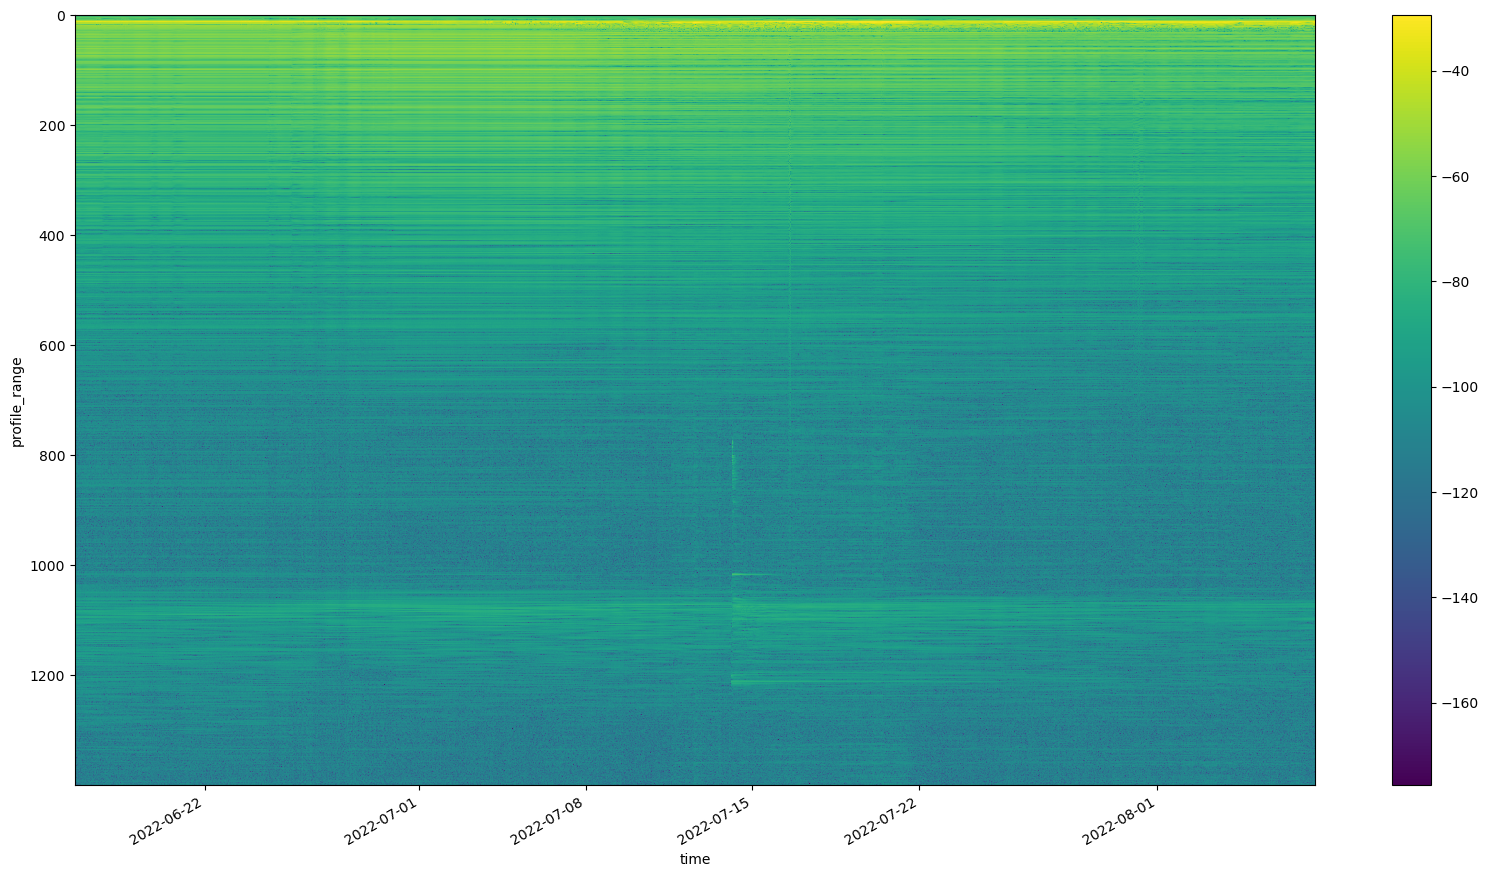

In [13]:
# Checking chirps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
xa.dB(longer).plot(ax=ax,x='time')
ax.invert_yaxis()
#ax1 = ax.twinx()
#data.Up.plot(ax=ax1,x='datetime',color='k')


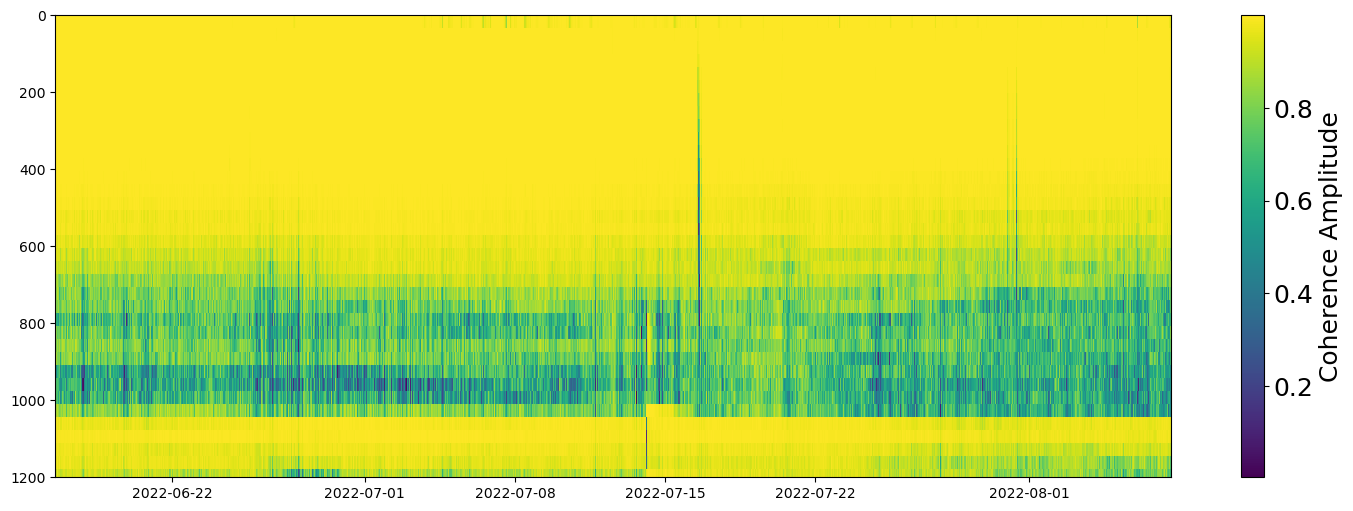

In [14]:
fig, ax = plt.subplots(figsize=(18,6))
im = plt.pcolormesh(ds.time,ds.profile_range,abs(co).transpose())
cb = fig.colorbar(im)
cb.set_label('Coherence Amplitude',fontsize=18)
cb.ax.tick_params(labelsize=18) 
ax.set_ylim([0,1200])
ax.invert_yaxis()


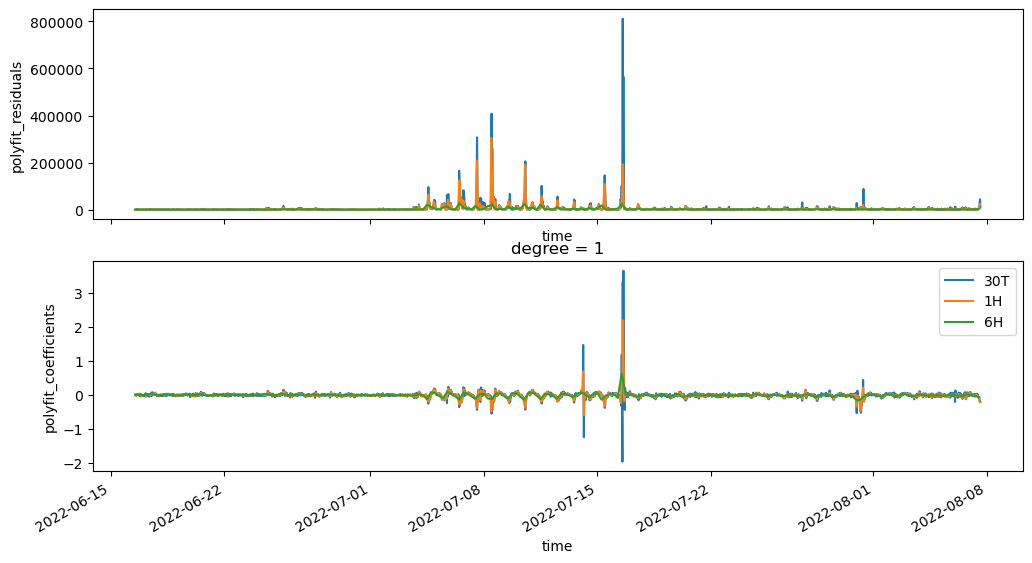

In [20]:
fig, ax = plt.subplots(nrows=2,figsize=(12,6),sharex=True)

for vd_sum in ['30T','1H','6H']:

    disp_stack = ds.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
    err_stack = ds.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1,full=True)
    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax[1],label=vd_sum)
    (strain_polyfit.polyfit_residuals).plot(ax = ax[0])
plt.legend()


In [19]:
len(disp_stack.where(disp_stack.profile_range <=500).profile_range)

41

In [21]:
ds=ds.assign(coherence=(['time','profile_range'],co))

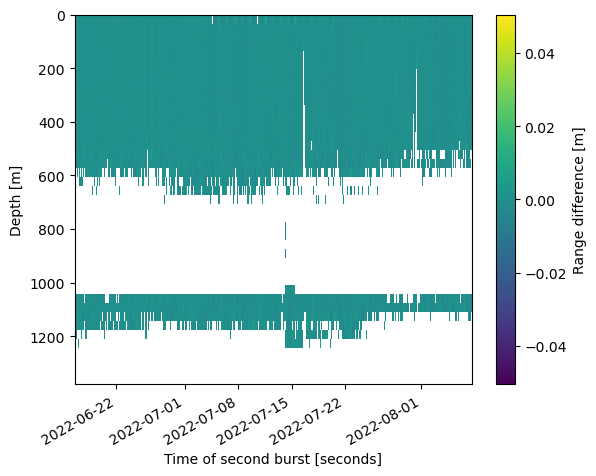

In [22]:
ds.range_diff.where(abs(ds.coherence) > 0.95).plot(x='time',cmap='viridis')
plt.gca().invert_yaxis()


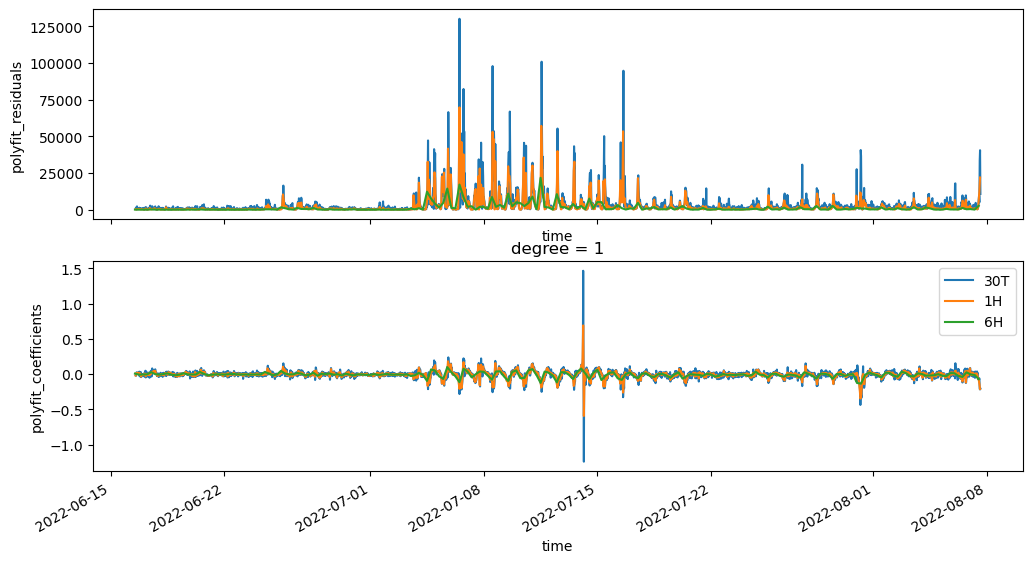

In [23]:
fig, ax = plt.subplots(nrows=2,figsize=(12,6),sharex=True)
new_ds = ds.where(abs(ds.coherence) > 0.95)
for vd_sum in ['30T','1H','6H']:

    disp_stack = new_ds.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
    err_stack = ds.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1,full=True)
    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax[1],label=vd_sum)
    strain_polyfit.polyfit_residuals.plot(ax = ax[0])
plt.legend()

In [24]:
# High residuals
shorter = da_101_stacked.isel(time=range(4640,4670))
b1 = shorter.isel(time=range(0,len(shorter)-1))
b2 = shorter.isel(time=range(1,len(shorter)))
ds, co, phi = xa.generate_range_diff(b1,b2,80,80,None,0,0.95)
ds=ds.assign(coherence=(['time','profile_range'],co))

INFO     15:59:10 	 ApRESDefs.py @function generate_range_diff line 669 - Time between bursts : [868. 900. 900. 901. 902. 899. 900. 900. 930. 870. 900. 900. 899. 901.
 900. 900. 900. 907. 895. 901. 902. 897. 904. 900. 903. 901. 901. 919.
 869.]s


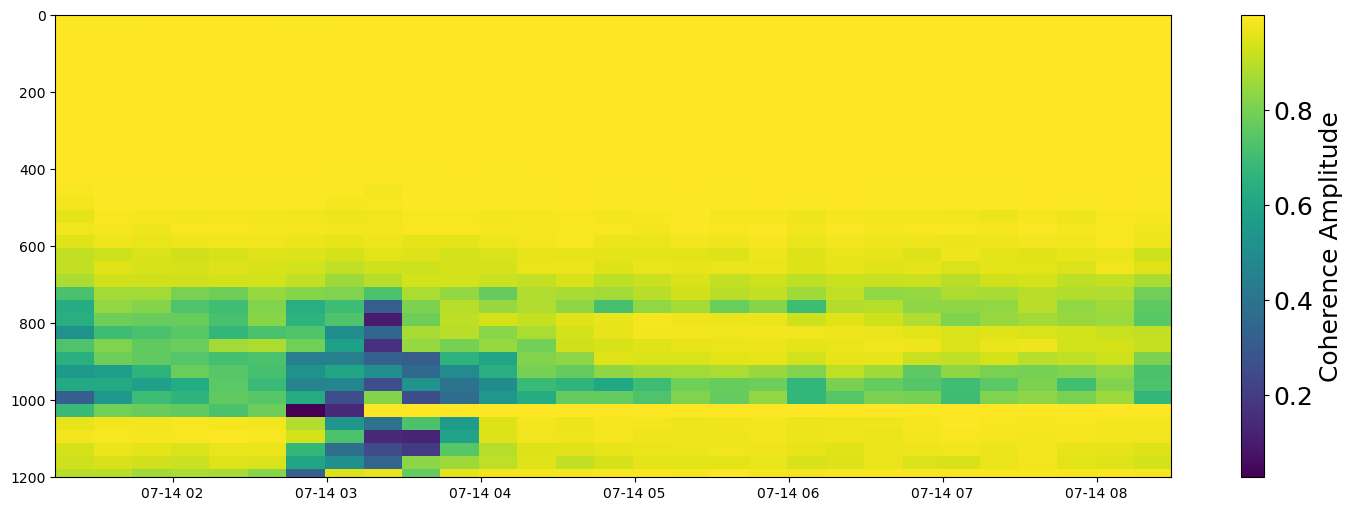

In [25]:
fig, ax = plt.subplots(figsize=(18,6))
im = plt.pcolormesh(ds.time,ds.profile_range,abs(co).transpose())
cb = fig.colorbar(im)
cb.set_label('Coherence Amplitude',fontsize=18)
cb.ax.tick_params(labelsize=18) 
ax.set_ylim([0,1200])
ax.invert_yaxis()


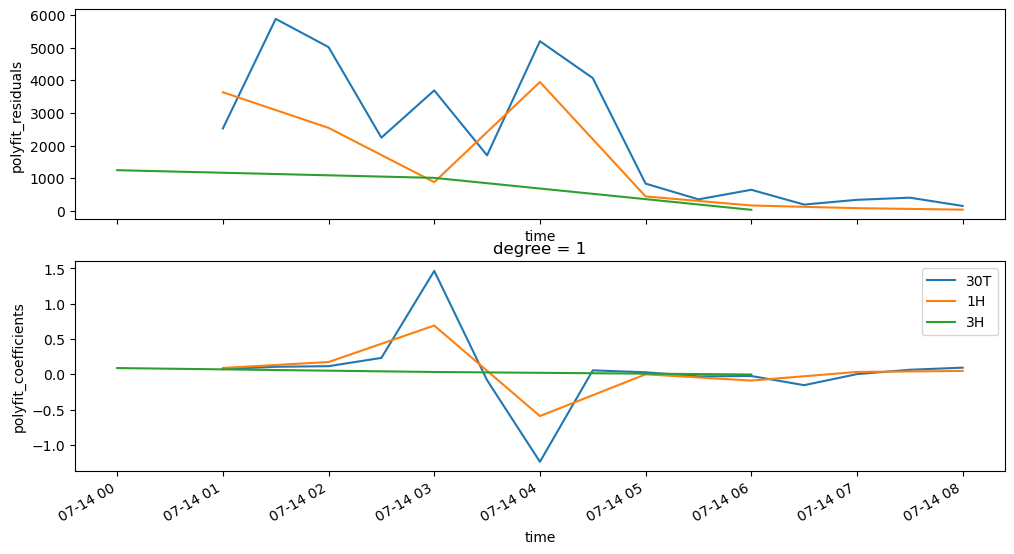

In [26]:
fig, ax = plt.subplots(nrows=2,figsize=(12,6),sharex=True)
new_ds = ds.where(abs(ds.coherence) > 0.95)
for vd_sum in ['30T','1H','3H']:

    disp_stack = new_ds.range_diff.resample(time=vd_sum).sum(dim='time')/convert_to_seconds(vd_sum)*31536000
    err_stack = ds.err.resample(time=vd_sum).apply(error_prop)/convert_to_seconds(vd_sum)*31536000
    strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1,full=True)
    strain_polyfit.polyfit_coefficients.sel(degree=1).plot(ax=ax[1],label=vd_sum)
    strain_polyfit.polyfit_residuals.plot(ax = ax[0])
plt.legend()

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

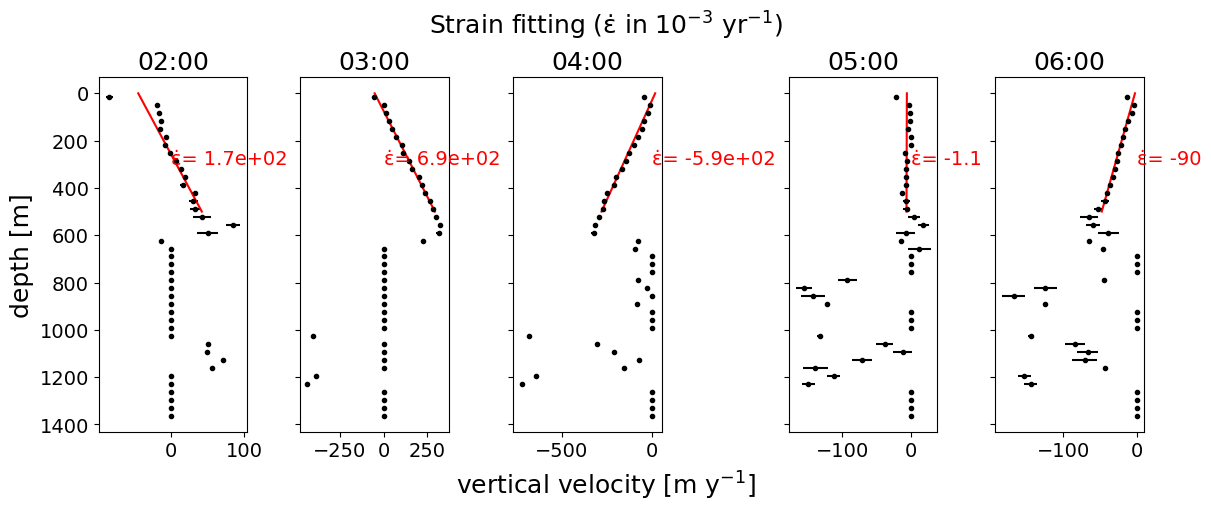

In [28]:
fig1, axs_1 = plt.subplots(ncols=5,figsize=(12,5),sharey=True,layout='constrained')
fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
# Plotting displacement for individual layers 
j = '1H'
disp_stack = new_ds.range_diff.resample(time=j).sum(dim='time')/convert_to_seconds(j)*31536000
err_stack = new_ds.err.resample(time=j).apply(error_prop)/convert_to_seconds(j)*31536000
strain_polyfit = disp_stack.where(disp_stack.profile_range <=500).polyfit('profile_range',1)
plt_count = 0
for i in np.arange(math.ceil(0.05*len(disp_stack.time)),len(disp_stack.time),len(disp_stack.time)//5):
    axs_1[plt_count].errorbar(disp_stack.isel(time = i) ,disp_stack.profile_range,yerr=None,xerr=err_stack.isel(time = i),linestyle='',marker='.',color='k')
    fit = strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(0,500)+strain_polyfit.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(fit,np.linspace(0,500),color='r')
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    axs_1[plt_count].text(0,300, f"\u03B5\u0307= {strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{disp_stack.time.isel(time = i).values.astype(str)[11:16]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-10,10])
    #axs_1[plt_count].set_ylim([0,600])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 5:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

In [146]:
strain_polyfit.polyfit_coefficients.sel(degree=1).isel(time=i).values

array(0.10578187)

In [29]:
disp_stack.profile_range

<xarray.DataArray 'profile_range' (profile_range: 41)>
array([  16.823165,   50.469494,   84.115823,  117.762152,  151.408482,
        185.054811,  218.70114 ,  252.347469,  285.993799,  319.640128,
        353.286457,  386.932786,  420.579116,  454.225445,  487.871774,
        521.518103,  555.164433,  588.810762,  622.457091,  656.10342 ,
        689.74975 ,  723.396079,  757.042408,  790.688737,  824.335067,
        857.981396,  891.627725,  925.274054,  958.920383,  992.566713,
       1026.213042, 1059.859371, 1093.5057  , 1127.15203 , 1160.798359,
       1194.444688, 1228.091017, 1261.737347, 1295.383676, 1329.030005,
       1362.676334])
Coordinates:
  * profile_range  (profile_range) float64 16.82 50.47 ... 1.329e+03 1.363e+03
Attributes:
    units:      m
    long_name:  Depth